In [1]:
import pprint
import random
import warnings

warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.datasets import load_diabetes
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split


In [2]:
from sklearn_expansion.experimental_design import create_optimal_design
from sklearn_expansion.experimental_design import BayesianOptimization
from sklearn_expansion import experimental_design
from sklearn_expansion.experimental_design import apply_rules_to_samples

実験空間から実験候補を提案する

手法

①：ベイズ最適化

②：実験計画法（D-最適基準）

③：ランダムサンプリング

In [3]:
# 実験空間（design space）の設定
X,y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=5)

X_design_space = X_test
print(len(X_design_space))
print(X_design_space.shape)
print(X_design_space[:2])

437
(437, 10)
[[ 0.04534098 -0.04464164 -0.00620595 -0.01599922  0.1250187   0.1251981
   0.019187    0.03430886  0.03243323 -0.0052198 ]
 [ 0.00175052 -0.04464164 -0.03961813 -0.10092337 -0.02908802 -0.03012354
   0.04495846 -0.05019471 -0.06832974 -0.12948301]]


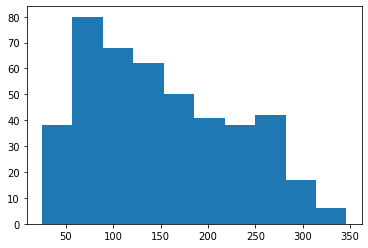

In [4]:
plt.hist(y)
plt.show()

In [5]:
# ①ベイズ最適化

# 既定のカーネルから適当に選択
kernels = BayesianOptimization.kernels()
pprint.pprint(kernels)
kernel = kernels[4]

[1**2 * DotProduct(sigma_0=1) + WhiteKernel(noise_level=1),
 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1) + 1**2 * DotProduct(sigma_0=1),
 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
 1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1) + 1**2 * DotProduct(sigma_0=1),
 1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1),
 1**2 * Matern(length_scale=1, nu=1.5) + WhiteKernel(noise_level=1) + 1**2 * DotProduct(sigma_0=1),
 1**2 * Matern(length_scale=1, nu=0.5) + WhiteKernel(noise_level=1),
 1**2 * Matern(length_scale=1, nu=0.5) + WhiteKernel(noise_level=1) + 1**2 * DotProduct(sigma_0=1),
 1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1),
 1**2 * Matern(length_scale=1, nu=2.5) + WhiteKernel(noise_level=1) + 1**2 * DotProduct(sigma_0=1)]


In [6]:
bo = BayesianOptimization()

# 目的変数の数
n_y=1
# 2以上の多目的最適化にも対応
# PTR, PIは確率の乗算
# EIは同じ重み付けでの加算
　　　# TODO：重みづけの設定

# 候補数
n_suggestion = 5
# ガウス過程のestimator
# GaussianProcessRegressorに限らず,return_stdが可能なestimatorであればOK
estimator = GaussianProcessRegressor(alpha=0,
                                             kernel=kernel,
                                             random_state=None,
                                             optimizer='fmin_l_bfgs_b')

# 目標特性を設定　下限：250（＆上限：無限） 
# つまりy>=250を目標とする

target_ranges = [{"lower":250, "upper":np.inf}]

# kriging_believerを用いて候補を提案
bo_Xs = bo.kriging_believer_algorithm(estimator=estimator,
                                        X=X_train,
                                        y=y_train,
                                        n_y=n_y,
                                        X_design=X_design_space,
                                        target_ranges=target_ranges,
                                        acquisition_function="PTR",
                                        n_suggestion=n_suggestion)

In [7]:
pd.DataFrame(bo_Xs)

,0,1,2,3,4,5,6,7,8,9
0,0.012648,-0.044642,0.026128,0.063187,0.125019,0.091691,0.063367,-0.002592,0.057573,-0.021788
1,-0.049105,-0.044642,0.160855,-0.046985,-0.029088,-0.019790,-0.047082,0.034309,0.028017,0.011349
2,-0.092695,-0.044642,-0.040696,-0.019442,-0.068991,-0.079288,0.041277,-0.076395,-0.041180,-0.096346
3,-0.023677,-0.044642,0.045529,0.090730,-0.018080,-0.035447,0.070730,-0.039493,-0.034524,-0.009362
4,0.045341,-0.044642,0.071397,0.001215,-0.009825,-0.001001,0.015505,-0.039493,-0.041180,-0.071494


In [8]:
# ②実験計画法（D,I,A,E,Gに対応）
X_optimal_design = create_optimal_design(X, n_experiments=5, optimal_type='D')

In [9]:
pd.DataFrame(X_optimal_design)

,0,1,2,3,4,5,6,7,8,9
0,0.005383,0.050680,0.034751,-0.001080,0.152538,0.198788,-0.061809,0.185234,0.015567,0.073480
1,0.009016,0.050680,-0.039618,0.028758,0.038334,0.073529,-0.072854,0.108111,0.015567,-0.046641
2,-0.027310,-0.044642,-0.060097,-0.029771,0.046589,0.019980,0.122273,-0.039493,-0.051401,-0.009362
3,-0.041840,-0.044642,0.047685,0.059744,0.127771,0.128016,-0.024993,0.108111,0.063893,0.040343
4,-0.060003,0.050680,0.054152,-0.019442,-0.049727,-0.048912,0.022869,-0.039493,-0.043985,-0.005220


In [10]:
# ③ランダムサンプリング

# 制約条件を以下の様に仮定する
# X0は0以上
# X1×X2 は0.5以下

rules = [
        # 組成0が0以上の制約条件を課す
        {"constraints": lambda i: i[0]>=0},
        # 組成1×組成2が0.5以下の制約条件を課す
        {"constraints": lambda i: i[1]*i[2]<=0.5},
        ]

X_random_sampling = apply_rules_to_samples(X_design_space, rules)
# 制約条件を満たさない候補はNone
X_random_sampling = [x for x in X_random_sampling if x is not None]
X_random_sampling = random.sample(X_random_sampling, 5)

pd.DataFrame(X_random_sampling)

,0,1,2,3,4,5,6,7,8,9
0,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
1,0.041708,0.050680,-0.043929,0.063187,-0.004321,0.016222,-0.013948,-0.002592,-0.034524,0.011349
2,0.001751,0.050680,-0.005128,-0.012556,-0.015328,-0.013840,0.008142,-0.039493,-0.006080,-0.067351
3,0.016281,-0.044642,-0.045007,-0.057314,-0.034592,-0.053923,0.074412,-0.076395,-0.042572,0.040343
4,0.052606,-0.044642,-0.021295,-0.074528,-0.040096,-0.037639,-0.006584,-0.039493,-0.000609,-0.054925
